# Parallel Scan Pattern with OpenMP

- **Author:** *Mariusz Wiśniewski*

## Task

- Implement a scan function that adds to each element of the input vector all the previous elements in the same vector.
- The implementation should use an *upsweep* + *downsweep* approach in order to efficiently compute the results in a parallel execution.
- Implement a second function for checking the correctness of the result if the original vector of size *n* contained, in order, all the values from *0* to *n-1*.
- After obtaining a working parallel implementation, evaluate the speedup offered by each parallel construct in your solution (tip: perform evaluation on a reasonably large vector).

In [1]:
!apt install libomp-dev

!mkdir /home/OpenMP
!mkdir /home/OpenMP/build/
!mkdir /home/OpenMP/output

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


## Serial scan

*OpenMP* was used here only to get consistent time measurements using *omp_get_wtime()* across the whole notebook.

In [2]:
%%writefile /home/OpenMP/serial_scan.c

#include <stdio.h>
#include <inttypes.h>
#include <stdbool.h>
#include <time.h>

#include <omp.h>

void scan(const uint64_t *in, uint64_t *out, const uint64_t size) {
    out[0] = in[0];
    for (uint64_t i = 1; i < size; i++) {
        out[i] = out[i - 1] + in[i];
        nanosleep(&(struct timespec) {.tv_sec=0, .tv_nsec=1}, NULL);
    }
}

bool check_result(const uint64_t *res, uint64_t size) {
    bool result = true;

    for (uint64_t i = 0; i < size; i++) {
        if (res[i] != i * (i + 1) / 2) {
            result = false;
        }
        nanosleep(&(struct timespec) {.tv_sec=0, .tv_nsec=1}, NULL);
    }

    return result;
}

int main(int argc, char *argv[]) {
    if (argc != 2) {
        printf("Expected 1 output but got %d\n", argc - 1);
        return 0;
    }

    uint64_t vecSize = strtoumax(argv[1], NULL, 10);
    uint64_t initialVals[vecSize], finalVals[vecSize];

    /* the input vector of size vecSize will contain all the integers
     * from 0 to vecSize - 1
     */
    for (uint64_t i = 0; i <= vecSize; i++) {
        initialVals[i] = i;
    }

    double start = omp_get_wtime();

    scan(initialVals, finalVals, vecSize);
    bool result = check_result(finalVals, vecSize);

    double end = omp_get_wtime();

    printf("The execution time is %fs.\n", end - start);
    printf("The result is %s.\n", result ? "correct" : "incorrect");

    return 0;
}

Writing /home/OpenMP/serial_scan.c


## Parallel scan

In [3]:
%%writefile /home/OpenMP/scan.c

#include <stdio.h>
#include <inttypes.h>
#include <stdbool.h>
#include <time.h>

#include <omp.h>

int scan(const uint64_t *in, uint64_t *out, uint64_t size) {
    int n_threads = 1;

#if defined(PARALLEL1) || defined(PARALLEL)
    // initialize the output array with the elements from the input array
#pragma omp parallel default(none) shared(in, out, size, n_threads)
    {
        n_threads = omp_get_num_threads();
#pragma omp for schedule(guided)
#endif
        for (uint64_t i = 0; i < size; i++) {
            out[i] = in[i];
            nanosleep(&(struct timespec) {.tv_sec=0, .tv_nsec=1}, NULL);
        }
#if defined(PARALLEL1) || defined(PARALLEL)
    }
#endif

    // upsweep (compute reduction)
    for (uint64_t stride = 1; stride < size; stride <<= 1) {
#if defined(PARALLEL2) || defined(PARALLEL)
#pragma omp parallel default(none) shared(in, out, size, stride, n_threads)
        {
            n_threads = omp_get_num_threads();
#pragma omp for schedule(guided)
#endif
            for (uint64_t i = 0; i < size; i += 2 * stride) {
                out[2 * stride + i - 1] = out[2 * stride + i - 1] + out[stride + i - 1];
                nanosleep(&(struct timespec) {.tv_sec=0, .tv_nsec=1}, NULL);
            }
#if defined(PARALLEL2) || defined(PARALLEL)      
        }
#endif
    }

    // clear the last element
    uint64_t last = out[size - 1];
    out[size - 1] = 0;

    // downsweep (compute intermediate values)
    for (uint64_t stride = size / 2; stride > 0; stride >>= 1) {
#if defined(PARALLEL3) || defined(PARALLEL)
#pragma omp parallel default(none) shared(in, out, size, stride, n_threads)
        {
            n_threads = omp_get_num_threads();
#pragma omp for schedule(guided)
#endif
            for (uint64_t i = 0; i < size; i += 2 * stride) {
                uint64_t temp = out[stride + i - 1];
                out[stride + i - 1] = out[2 * stride + i - 1];
                out[2 * stride + i - 1] = temp + out[2 * stride + i - 1];
                nanosleep(&(struct timespec) {.tv_sec=0, .tv_nsec=1}, NULL);
            }
#if defined(PARALLEL3) || defined(PARALLEL)
        }
#endif
    }

    // shift left for performing the inclusive scan and add the last element
    for (uint64_t i = 0; i < size - 1; i++) {
        out[i] = out[i + 1];
    }
    out[size - 1] = last;

    return n_threads;
}

bool check_result(const uint64_t *res, uint64_t size) {
    bool result = true;

#if defined(PARALLEL4) || defined(PARALLEL)
#pragma omp parallel for schedule(guided) default(none) shared(res, size, result)
#endif
    for (uint64_t i = 0; i < size; i++) {
        if (res[i] != i * (i + 1ul) / 2ul) {
            result = false;
        }
        nanosleep(&(struct timespec) {.tv_sec=0, .tv_nsec=1}, NULL);
    }

    return result;
}

int main(int argc, char *argv[]) {
    if (argc != 2) {
        printf("Expected 1 output but got %d\n", argc - 1);
        return 0;
    }

    uint64_t vecSize = strtoumax(argv[1], NULL, 10);
    uint64_t initialVals[vecSize], finalVals[vecSize];

    /* the input vector of size vecSize will contain all the integers
     * from 0 to vecSize - 1
     */
    for (uint64_t i = 0; i <= vecSize; i++) {
        initialVals[i] = i;
    }

    double start = omp_get_wtime();

    int n_threads = scan(initialVals, finalVals, vecSize);
    bool result = check_result(finalVals, vecSize);

    double end = omp_get_wtime();

    printf("The number of threads is %d.\n", n_threads);
    printf("The execution time is %fs.\n", end - start);
    printf("The result is %s.\n", result ? "correct" : "incorrect");

    return 0;
}

Writing /home/OpenMP/scan.c


## Building code

In [4]:
%cd /home/OpenMP
!gcc -fopenmp serial_scan.c -o build/serial_scan -lm
!gcc -fopenmp scan.c -o build/scan_np -lm

/home/OpenMP


In [5]:
!gcc -fopenmp -DPARALLEL1 scan.c -o build/scan_p1 -lm
!gcc -fopenmp -DPARALLEL2 scan.c -o build/scan_p2 -lm
!gcc -fopenmp -DPARALLEL3 scan.c -o build/scan_p3 -lm
!gcc -fopenmp -DPARALLEL4 scan.c -o build/scan_p4 -lm
!gcc -fopenmp -DPARALLEL scan.c -o build/scan_fp

## Running experiments

### Serial scan

In [6]:
!./build/serial_scan 262144 | tee /home/OpenMP/output/serial.log

The execution time is 33.632808s.
The result is correct.


### No paralellization

In [7]:
!OMP_NUM_THREADS=1 ./build/scan_np 262144 | tee /home/OpenMP/output/np.log

The number of threads is 1.
The execution time is 65.056693s.
The result is correct.


### Output array initialization parallelization

In [8]:
!OMP_NUM_THREADS=2 ./build/scan_p1 262144 | tee /home/OpenMP/output/p1.log
!OMP_NUM_THREADS=4 ./build/scan_p1 262144 | tee -a /home/OpenMP/output/p1.log
!OMP_NUM_THREADS=8 ./build/scan_p1 262144 | tee -a /home/OpenMP/output/p1.log
!OMP_NUM_THREADS=16 ./build/scan_p1 262144 | tee -a /home/OpenMP/output/p1.log

The number of threads is 2.
The execution time is 57.782748s.
The result is correct.
The number of threads is 4.
The execution time is 52.921742s.
The result is correct.
The number of threads is 8.
The execution time is 50.609610s.
The result is correct.
The number of threads is 16.
The execution time is 49.739254s.
The result is correct.


### Upsweep parallelization

In [9]:
!OMP_NUM_THREADS=2 ./build/scan_p2 262144 | tee /home/OpenMP/output/p2.log
!OMP_NUM_THREADS=4 ./build/scan_p2 262144 | tee -a /home/OpenMP/output/p2.log
!OMP_NUM_THREADS=8 ./build/scan_p2 262144 | tee -a /home/OpenMP/output/p2.log
!OMP_NUM_THREADS=16 ./build/scan_p2 262144 | tee -a /home/OpenMP/output/p2.log

The number of threads is 2.
The execution time is 57.928061s.
The result is correct.
The number of threads is 4.
The execution time is 53.201097s.
The result is correct.
The number of threads is 8.
The execution time is 50.852335s.
The result is correct.
The number of threads is 16.
The execution time is 49.777099s.
The result is correct.


### Downsweep parallelization

In [10]:
!OMP_NUM_THREADS=2 ./build/scan_p3 262144 | tee /home/OpenMP/output/p3.log
!OMP_NUM_THREADS=4 ./build/scan_p3 262144 | tee -a /home/OpenMP/output/p3.log
!OMP_NUM_THREADS=8 ./build/scan_p3 262144 | tee -a /home/OpenMP/output/p3.log
!OMP_NUM_THREADS=16 ./build/scan_p3 262144 | tee -a /home/OpenMP/output/p3.log

The number of threads is 2.
The execution time is 57.826980s.
The result is correct.
The number of threads is 4.
The execution time is 53.164321s.
The result is correct.
The number of threads is 8.
The execution time is 50.932711s.
The result is correct.
The number of threads is 16.
The execution time is 50.229992s.
The result is correct.


### Result verification parallelization

The number of threads is set to 1 here because the function *check_results* does not set that variable.

In [11]:
!OMP_NUM_THREADS=2 ./build/scan_p4 262144 | tee /home/OpenMP/output/p4.log
!OMP_NUM_THREADS=4 ./build/scan_p4 262144 | tee -a /home/OpenMP/output/p4.log
!OMP_NUM_THREADS=8 ./build/scan_p4 262144 | tee -a /home/OpenMP/output/p4.log
!OMP_NUM_THREADS=16 ./build/scan_p4 262144 | tee -a /home/OpenMP/output/p4.log

The number of threads is 1.
The execution time is 58.219114s.
The result is correct.
The number of threads is 1.
The execution time is 52.891824s.
The result is correct.
The number of threads is 1.
The execution time is 51.155068s.
The result is correct.
The number of threads is 1.
The execution time is 49.833155s.
The result is correct.


### Full parallelization

In [12]:
!OMP_NUM_THREADS=2 ./build/scan_fp 262144 | tee /home/OpenMP/output/fp.log
!OMP_NUM_THREADS=4 ./build/scan_fp 262144 | tee -a /home/OpenMP/output/fp.log
!OMP_NUM_THREADS=8 ./build/scan_fp 262144 | tee -a /home/OpenMP/output/fp.log
!OMP_NUM_THREADS=16 ./build/scan_fp 262144 | tee -a /home/OpenMP/output/fp.log

The number of threads is 2.
The execution time is 36.847159s.
The result is correct.
The number of threads is 4.
The execution time is 17.316232s.
The result is correct.
The number of threads is 8.
The execution time is 9.376328s.
The result is correct.
The number of threads is 16.
The execution time is 5.081094s.
The result is correct.


### Visualizing results

In [13]:
#@title
import re
from itertools import repeat

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 40)
plt.style.use('seaborn-whitegrid')

In [14]:
#@title
OUTPUT_DIR = '/home/OpenMP/output'
PARALLELIZATION_BLOCKS = ['Output array initialization', 'Upsweep', 'Downsweep', 'Result verification']

serial = [float(item) for sublist in [re.findall(r'(\d+\.\d+)', line)
            for line in open(f'{OUTPUT_DIR}/serial.log')] for item in sublist]
np = [float(item) for sublist in [re.findall(r'(\d+\.\d+)', line)
            for line in open(f'{OUTPUT_DIR}/np.log')] for item in sublist]
p1 = [float(item) for sublist in [re.findall(r'(\d+\.\d+)', line)
            for line in open(f'{OUTPUT_DIR}/p1.log')] for item in sublist]
p2 = [float(item) for sublist in [re.findall(r'(\d+\.\d+)', line)
            for line in open(f'{OUTPUT_DIR}/p2.log')] for item in sublist]
p3 = [float(item) for sublist in [re.findall(r'(\d+\.\d+)', line)
            for line in open(f'{OUTPUT_DIR}/p3.log')] for item in sublist]
p4 = [float(item) for sublist in [re.findall(r'(\d+\.\d+)', line)
            for line in open(f'{OUTPUT_DIR}/p4.log')] for item in sublist]
fp = [float(item) for sublist in [re.findall(r'(\d+\.\d+)', line)
            for line in open(f'{OUTPUT_DIR}/fp.log')] for item in sublist]

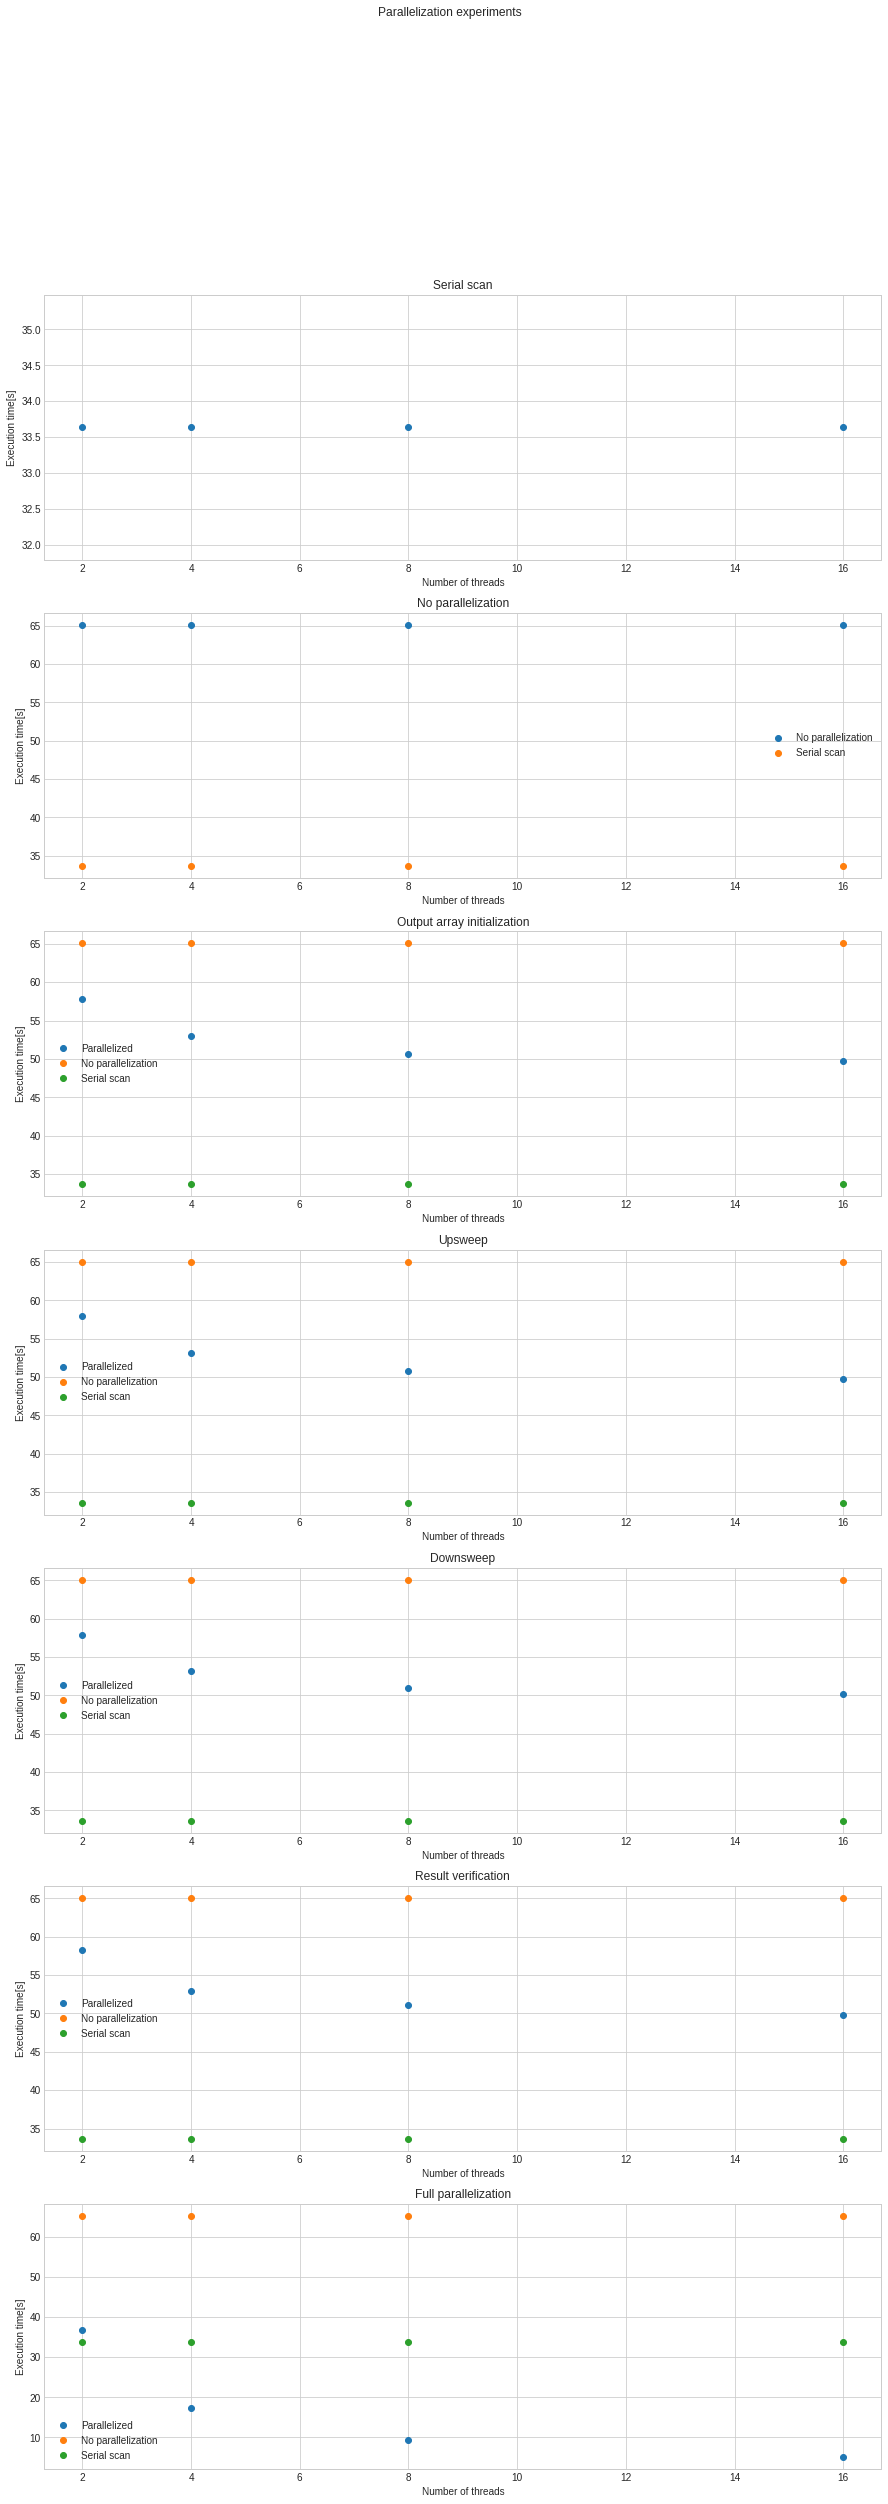

In [15]:
#@title
N_THREADS = [2, 4, 8, 16]

plt.suptitle('Parallelization experiments')

plt.subplot(7, 1, 1)
plt.title('Serial scan')
plt.xlabel('Number of threads')
plt.ylabel('Execution time[s]')
plt.plot(N_THREADS, [x for item in serial for x in repeat(item, len(N_THREADS))], 
         linestyle='', marker='o')

plt.subplot(7, 1, 2)
plt.title('No parallelization')
plt.xlabel('Number of threads')
plt.ylabel('Execution time[s]')
plt.plot(N_THREADS, [x for item in np for x in repeat(item, len(N_THREADS))], 
         linestyle='', marker='o', label='No parallelization')
plt.plot(N_THREADS, [x for item in serial for x in repeat(item, len(N_THREADS))], 
         linestyle='', marker='o', label='Serial scan')
plt.legend()

plt.subplot(7, 1, 3)
plt.title(PARALLELIZATION_BLOCKS[0])
plt.xlabel('Number of threads')
plt.ylabel('Execution time[s]')
plt.plot(N_THREADS, p1, linestyle='', marker='o', label='Parallelized')
plt.plot(N_THREADS, [x for item in np for x in repeat(item, len(N_THREADS))], 
         linestyle='', marker='o', label='No parallelization')
plt.plot(N_THREADS, [x for item in serial for x in repeat(item, len(N_THREADS))], 
         linestyle='', marker='o', label='Serial scan')
plt.legend()

plt.subplot(7, 1, 4)
plt.title(PARALLELIZATION_BLOCKS[1])
plt.xlabel('Number of threads')
plt.ylabel('Execution time[s]')
plt.plot(N_THREADS, p2, linestyle='', marker='o', label='Parallelized')
plt.plot(N_THREADS, [x for item in np for x in repeat(item, len(N_THREADS))], 
         linestyle='', marker='o', label='No parallelization')
plt.plot(N_THREADS, [x for item in serial for x in repeat(item, len(N_THREADS))], 
         linestyle='', marker='o', label='Serial scan')
plt.legend()

plt.subplot(7, 1, 5)
plt.title(PARALLELIZATION_BLOCKS[2])
plt.xlabel('Number of threads')
plt.ylabel('Execution time[s]')
plt.plot(N_THREADS, p3, linestyle='', marker='o', label='Parallelized')
plt.plot(N_THREADS, [x for item in np for x in repeat(item, len(N_THREADS))], 
         linestyle='', marker='o', label='No parallelization')
plt.plot(N_THREADS, [x for item in serial for x in repeat(item, len(N_THREADS))], 
         linestyle='', marker='o', label='Serial scan')
plt.legend()

plt.subplot(7, 1, 6)
plt.title(PARALLELIZATION_BLOCKS[3])
plt.xlabel('Number of threads')
plt.ylabel('Execution time[s]')
plt.plot(N_THREADS, p4, linestyle='', marker='o', label='Parallelized')
plt.plot(N_THREADS, [x for item in np for x in repeat(item, len(N_THREADS))], 
         linestyle='', marker='o', label='No parallelization')
plt.plot(N_THREADS, [x for item in serial for x in repeat(item, len(N_THREADS))], 
         linestyle='', marker='o', label='Serial scan')
plt.legend()

plt.subplot(7, 1, 7)
plt.title('Full parallelization')
plt.xlabel('Number of threads')
plt.ylabel('Execution time[s]')
plt.plot(N_THREADS, fp, linestyle='', marker='o', label='Parallelized')
plt.plot(N_THREADS, [x for item in np for x in repeat(item, len(N_THREADS))], 
         linestyle='', marker='o', label='No parallelization')
plt.plot(N_THREADS, [x for item in serial for x in repeat(item, len(N_THREADS))], 
         linestyle='', marker='o', label='Serial scan')
plt.legend()

plt.show()

### Full parallelization experiments

In [16]:
#@title
!OMP_NUM_THREADS=1 ./build/scan_fp 16 | tee /home/OpenMP/output/fp16_threads.log
!OMP_NUM_THREADS=2 ./build/scan_fp 16 | tee -a /home/OpenMP/output/fp16_threads.log
!OMP_NUM_THREADS=4 ./build/scan_fp 16 | tee -a /home/OpenMP/output/fp16_threads.log
!OMP_NUM_THREADS=8 ./build/scan_fp 16 | tee -a /home/OpenMP/output/fp16_threads.log
!OMP_NUM_THREADS=16 ./build/scan_fp 16 | tee -a /home/OpenMP/output/fp16_threads.log

The number of threads is 1.
The execution time is 0.009757s.
The result is correct.
The number of threads is 2.
The execution time is 0.002984s.
The result is correct.
The number of threads is 4.
The execution time is 0.002503s.
The result is correct.
The number of threads is 8.
The execution time is 0.004231s.
The result is correct.
The number of threads is 16.
The execution time is 0.002864s.
The result is correct.


In [17]:
#@title
!OMP_NUM_THREADS=1 ./build/scan_fp 1024 | tee /home/OpenMP/output/fp1024_threads.log
!OMP_NUM_THREADS=2 ./build/scan_fp 1024 | tee -a /home/OpenMP/output/fp1024_threads.log
!OMP_NUM_THREADS=4 ./build/scan_fp 1024 | tee -a /home/OpenMP/output/fp1024_threads.log
!OMP_NUM_THREADS=8 ./build/scan_fp 1024 | tee -a /home/OpenMP/output/fp1024_threads.log
!OMP_NUM_THREADS=16 ./build/scan_fp 1024 | tee -a /home/OpenMP/output/fp1024_threads.log

The number of threads is 1.
The execution time is 0.263991s.
The result is correct.
The number of threads is 2.
The execution time is 0.147992s.
The result is correct.
The number of threads is 4.
The execution time is 0.083043s.
The result is correct.
The number of threads is 8.
The execution time is 0.043550s.
The result is correct.
The number of threads is 16.
The execution time is 0.027584s.
The result is correct.


In [18]:
#@title
!OMP_NUM_THREADS=1 ./build/scan_fp 262144 | tee /home/OpenMP/output/fp262144_threads.log
!OMP_NUM_THREADS=2 ./build/scan_fp 262144 | tee -a /home/OpenMP/output/fp262144_threads.log
!OMP_NUM_THREADS=4 ./build/scan_fp 262144 | tee -a /home/OpenMP/output/fp262144_threads.log
!OMP_NUM_THREADS=8 ./build/scan_fp 262144 | tee -a /home/OpenMP/output/fp262144_threads.log
!OMP_NUM_THREADS=16 ./build/scan_fp 262144 | tee -a /home/OpenMP/output/fp262144_threads.log

The number of threads is 1.
The execution time is 64.677387s.
The result is correct.
The number of threads is 2.
The execution time is 36.623543s.
The result is correct.
The number of threads is 4.
The execution time is 17.033845s.
The result is correct.
The number of threads is 8.
The execution time is 9.521113s.
The result is correct.
The number of threads is 16.
The execution time is 5.156563s.
The result is correct.


### Visualizing results

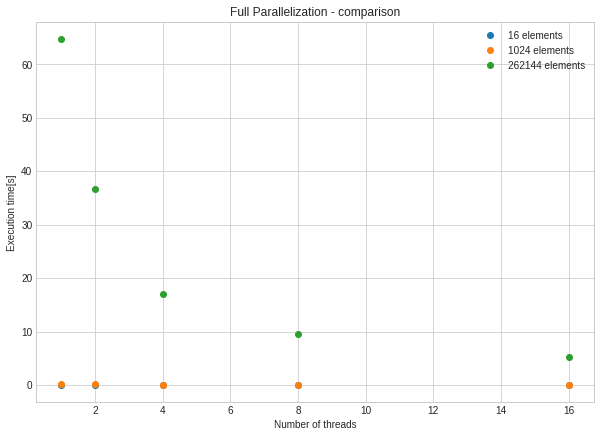

In [19]:
#@title
fp16 = [float(item) for sublist in [re.findall(r'(\d+\.\d+)', line)
            for line in open(f'{OUTPUT_DIR}/fp16_threads.log')] for item in sublist]
fp1024 = [float(item) for sublist in [re.findall(r'(\d+\.\d+)', line)
            for line in open(f'{OUTPUT_DIR}/fp1024_threads.log')] for item in sublist]
fp262144 = [float(item) for sublist in [re.findall(r'(\d+\.\d+)', line)
            for line in open(f'{OUTPUT_DIR}/fp262144_threads.log')] for item in sublist]

N_THREADS = [1, 2, 4, 8, 16]
plt.rcParams["figure.figsize"] = (10, 7)

plt.title('Full Parallelization - comparison')
plt.xlabel('Number of threads')
plt.ylabel('Execution time[s]')
plt.plot(N_THREADS, fp16, linestyle='', marker='o', label='16 elements')
plt.plot(N_THREADS, fp1024, linestyle='', marker='o', label='1024 elements')
plt.plot(N_THREADS, fp262144, linestyle='', marker='o', label='262144 elements')
plt.legend()
plt.show()

## Comments

The scan algorithm was parallelized in four places:
- output array initialization,
- upsweep,
- downsweep,
- result verification.

Each parallelization increased algorithm's performance, which can be observed in the provided visualizations. Furthermore, fully parallelized algorithm using 16 threads executes on 262144 elements about 6.6 times faster than the serial approach. It can be also noticed that the greater the number of threads, the faster the execution time.